In [1]:
%load_ext autoreload
%autoreload 2
%run Datasets.ipynb
import numpy as np
from keras import Input, Model
from keras.src.layers import Dense, BatchNormalization, GaussianNoise
from src import HammingCode


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-06-10 10:42:33.301677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 10:42:33.301921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 10:42:33.328957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-10 10:42:33.428765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 10:42:34.994521: W tensorflow/compiler/tf2

In [2]:
code_rate = 4/7
neurons = 7

entrada = Input(shape=(SIZE,))
encoder1 = Dense(SIZE, activation='relu')(entrada)
encoder2 = Dense(neurons, activation='linear')(encoder1)
encoder3 = BatchNormalization()(encoder2)


Eb_treinamento = 5.01187 * code_rate

noise = GaussianNoise(np.sqrt(1/(2* Eb_treinamento)))(encoder3)

decoder1 = Dense(SIZE, activation='relu')(noise)
decoder2 = Dense(SIZE, activation='softmax')(decoder1)

autoencoder = Model(entrada, decoder2)
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
autoencoder.fit(
    training_data,
    training_data,
    epochs=20,
    batch_size=300,
    validation_data=(validation_data, validation_data),
)

# Com o modelo treinado, separa em encoder e decoder
encoder = Model(entrada, encoder3)

entrada_encoder = Input(shape=(7,))
decoder_layer1 = autoencoder.layers[-2](entrada_encoder)
decoder_layer2 = autoencoder.layers[-1](decoder_layer1)
decoder = Model(entrada_encoder, decoder_layer2)

Epoch 1/20
34/34 [==============================] - 2s 14ms/step - loss: 1.2509 - accuracy: 0.1559 - val_loss: 1.2259 - val_accuracy: 0.2800
Epoch 2/20
34/34 [==============================] - 0s 7ms/step - loss: 1.0138 - accuracy: 0.3297 - val_loss: 1.1259 - val_accuracy: 0.2800
Epoch 3/20
34/34 [==============================] - 0s 6ms/step - loss: 0.8616 - accuracy: 0.5222 - val_loss: 1.0275 - val_accuracy: 0.5340
Epoch 4/20
34/34 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.7164 - val_loss: 0.9070 - val_accuracy: 0.5340
Epoch 5/20
34/34 [==============================] - 0s 5ms/step - loss: 0.5146 - accuracy: 0.9681 - val_loss: 0.7700 - val_accuracy: 0.7570
Epoch 6/20
34/34 [==============================] - 0s 5ms/step - loss: 0.3657 - accuracy: 0.9938 - val_loss: 0.6145 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 0s 5ms/step - loss: 0.2584 - accuracy: 0.9974 - val_loss: 0.4612 - val_accuracy: 1.0000
Epoch 8/20
34/34 [=

In [4]:
from math import erfc

Eb_dB_values = np.arange(-4, 11, 1)
ber_autoencoder = []
ber_Hamming = []
ber_teorica = []
for i in range(0, len(Eb_dB_values)):
    
    Eb = 10**(Eb_dB_values[i]/10)
    quantidade_amostras = test_length / SIZE
    noise = np.sqrt((1/(2*code_rate*Eb))) * np.random.randn(test_length, 7)    
    #ruido_encoded =  np.sqrt(1/(2*code_rate*Eb)) *  np.random.normal(0, np.sqrt(1/2), size=int(test_length*7))
    #noise = np.array_split(ruido_encoded, int(len(ruido_encoded)/7))
    # codifica para 7 bits
    codificado = encoder.predict(testing_data)
    
    #print(codificado)
    # add ruido
    codificado_com_ruido = codificado + noise
    
    #corrige com o decoder
    corrigido = decoder.predict(codificado_com_ruido)
    
    digital = np.argmax(corrigido, axis = 1)
    
    erros = digital != testing_label
    erros = erros.astype(int).sum()
    calculated_ber = erros/test_length
    ber_autoencoder.append(calculated_ber)
    print('SNR ', Eb_dB_values[i], 'BER ', calculated_ber)
    
    # Hamming code
    # Merge sample to encode
    merged_sample = np.concatenate(testing_data)
    split_encoded_data, split_original_data, merged_encoded_data = HammingCode.encode_sample(merged_sample)

    # Add noise
    merged_encoded_data = [1.0 if bit == 1 else -1.0 for bit in merged_encoded_data]
    merged_noise = np.concatenate(noise)
    merged_encoded_data = merged_encoded_data + np.array(merged_noise)
    digital_encoded_noisy = np.array([1 if x > 0 else 0.0 for x in merged_encoded_data])
    
    split_digital_encoded_noisy = np.array_split(digital_encoded_noisy, int(len(digital_encoded_noisy)/7))
    
    decoded_sample = HammingCode.decode_sample(split_digital_encoded_noisy)

        
    calculated_ber_Hamming = np.sum(np.array(decoded_sample).astype(int) != merged_sample.astype(int)) / len(merged_sample)
    ber_Hamming.append(calculated_ber_Hamming)
    
    print('SNR ', Eb_dB_values[i], 'BER ', calculated_ber_Hamming)
    
    BER_teorica_codificado = 0.5 * erfc(np.sqrt(Eb))
    ber_teorica.append(BER_teorica_codificado)


3125/3125 [==============================] - 6s 2ms/step
SNR  -4 BER  0.11544
SNR  -4 BER  0.260665
3125/3125 [==============================] - 6s 2ms/step
SNR  -3 BER  0.07768
SNR  -3 BER  0.22993
3125/3125 [==============================] - 6s 2ms/step
SNR  -2 BER  0.04958
SNR  -2 BER  0.1936875
3125/3125 [==============================] - 6s 2ms/step
SNR  -1 BER  0.02974
SNR  -1 BER  0.156565
3125/3125 [==============================] - 6s 2ms/step
SNR  0 BER  0.01554
SNR  0 BER  0.119
3125/3125 [==============================] - 6s 2ms/step
SNR  1 BER  0.00694
SNR  1 BER  0.0845575
3125/3125 [==============================] - 6s 2ms/step
SNR  2 BER  0.00269
SNR  2 BER  0.055095
3125/3125 [==============================] - 6s 2ms/step
SNR  3 BER  0.00092
SNR  3 BER  0.031835
3125/3125 [==============================] - 6s 2ms/step
SNR  4 BER  0.00024
SNR  4 BER  0.0155475
3125/3125 [==============================] - 6s 2ms/step
SNR  5 BER  5e-05
SNR  5 BER  0.006805
3125/3125 [====

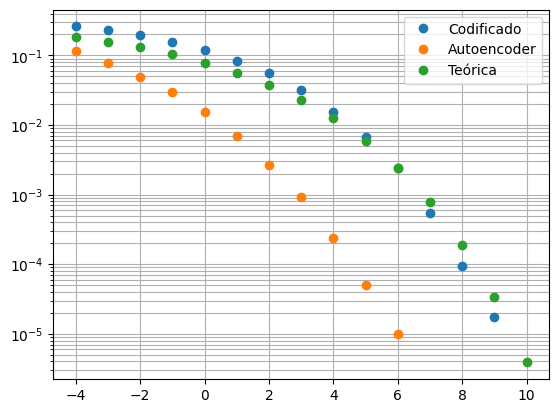

In [5]:
from matplotlib import pyplot as plt

plt.semilogy(Eb_dB_values, ber_Hamming, marker='o', linestyle='', label='Codificado')
plt.semilogy(Eb_dB_values, ber_autoencoder, marker='o', linestyle='', label='Autoencoder')
plt.semilogy(Eb_dB_values, ber_teorica, marker='o', linestyle='', label='Teórica')

plt.legend()
plt.grid(True, which='both')

plt.show()
